In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install opencv-python
!pip install rasterio opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 92.4 MB/s eta 0:00:00


Media măști binare (mean): 166.21090870803408
AVG: 40
Prag final: 206.21090870803408
Pixeli nisip (mean): 462360
Pixeli total (mean): 12424941
Procentaj pixeli cu nisip (CI mean): 3.72%


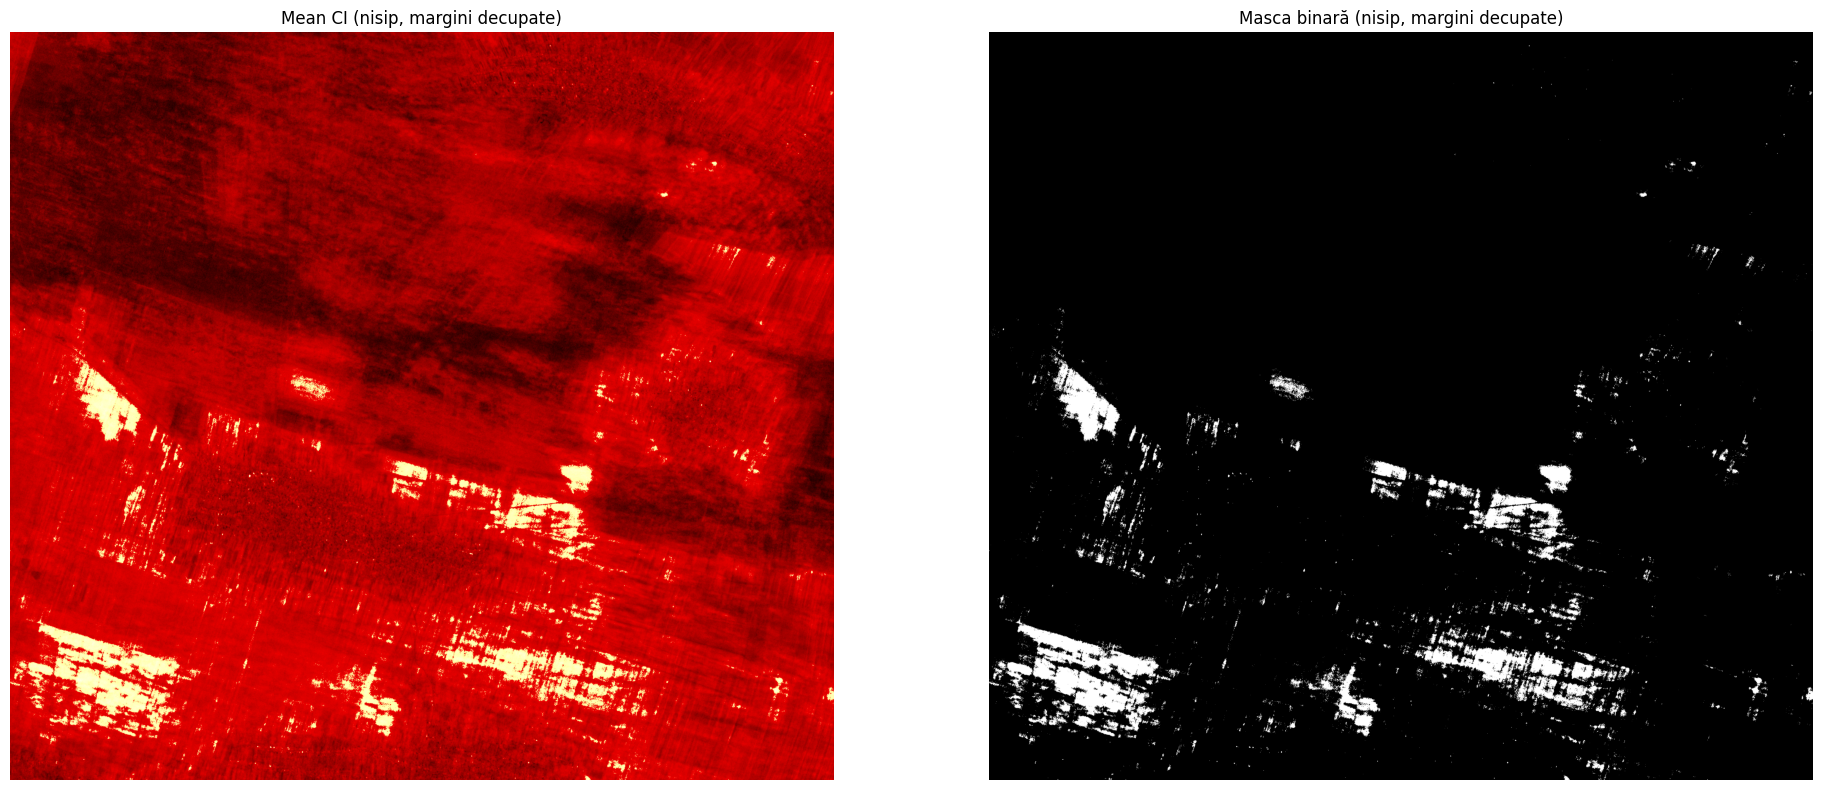

In [ ]:
# Crust Index 2021

import rasterio
from matplotlib import pyplot as plt
import numpy as np
import cv2

base_path = '/content/drive/MyDrive/img/'
months_2021 = ['mar2021_1', 'apr2021_1', 'may2021_1', 'jun2021_1', 'jul2021_1',
               'aug2021_1', 'sep2021_1', 'oct2021_1', 'nov2021_1']

file_paths = [base_path + month + '.tif' for month in months_2021]

# Funcția pentru a calcula CI
def compute_ci_from_file(file_path):
    with rasterio.open(file_path) as src:
        red = src.read(3).astype(float)  # Banda 3: Roșu
        blue = src.read(1).astype(float) # Banda 1: Albastru
        numerator = red - blue
        denominator = red + blue
        ci = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator!=0)
        return ci

# Calcul CI și determinare dimensiune minimă
index_values = []
min_height = float('inf')
min_width = float('inf')

for fp in file_paths:
    ci = compute_ci_from_file(fp)
    index_values.append(ci)
    height, width = ci.shape
    min_height = min(min_height, height)
    min_width = min(min_width, width)

# Redimensionare
dimensions = (min_width, min_height)
index_resized = [cv2.resize(index, dimensions, interpolation=cv2.INTER_NEAREST) for index in index_values]
# index_resized = [cv2.resize(index, dimensions) for index in index_values]

# Normalizare
def normalize_image(image):
    return cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

index_normalized = [normalize_image(index) for index in index_resized]

# Calcul medie
index_mean = np.mean(index_normalized, axis=0).astype(np.uint8)
index_mean_normalized = normalize_image(index_mean)

# Măști binare adaptive
binary_masks = [cv2.adaptiveThreshold(index_n, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                      cv2.THRESH_BINARY, 11, 2) for index_n in index_normalized]
binary_mask_mean = cv2.adaptiveThreshold(index_mean_normalized, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                         cv2.THRESH_BINARY, 11, 2)

# Prag ajustat
m_values = [np.mean(mask) for mask in binary_masks]
m_mean = np.mean(binary_mask_mean)
print(f"Media măști binare (mean): {m_mean}")

avg = 40
print(f"AVG: {avg}")
threshold = m_mean + avg
print(f"Prag final: {threshold}")

# Aplică pragurile
binary_masks = [cv2.threshold(index_n, m, 255, cv2.THRESH_BINARY)[1]
                for index_n, m in zip(index_normalized, m_values)]
_, binary_mask_mean = cv2.threshold(index_mean_normalized, threshold, 255, cv2.THRESH_BINARY)

# Overlay
def create_overlay(base_image, binary_mask):
    return cv2.addWeighted(base_image, 0.5, binary_mask, 0.5, 0)

overlays = [create_overlay(index_n, mask) for index_n, mask in zip(index_normalized, binary_masks)]
overlay_mean = create_overlay(index_mean_normalized, binary_mask_mean)

crop_percent_sides = 0.13  # pentru stânga/dreapta
crop_percent_top = 0.20    # pentru sus
crop_percent_bottom = 0.13 # pentru jos

height, width = overlay_mean.shape[:2]
crop_height_top = int(height * crop_percent_top)      # Pixeli decupați sus
crop_height_bottom = int(height * crop_percent_bottom) # Pixeli decupați jos
crop_width = int(width * crop_percent_sides)          # Pixeli decupați stânga/dreapta

# Calculează noile coordonate
y_start = crop_height_top
y_end = height - crop_height_bottom
x_start = crop_width
x_end = width - crop_width

# Aplică decuparea
cropped_overlay_mean = overlay_mean[y_start:y_end, x_start:x_end]
cropped_binary_mask_mean = binary_mask_mean[y_start:y_end, x_start:x_end]

# Procent pixeli de nisip
sand_pixels = np.sum(cropped_binary_mask_mean == 255)
total_pixels = cropped_binary_mask_mean.shape[0] * cropped_binary_mask_mean.shape[1]
sand_percentage = (sand_pixels / total_pixels) * 100
print(f"Pixeli nisip (mean): {sand_pixels}")
print(f"Pixeli total (mean): {total_pixels}")
print(f"Procentaj pixeli cu nisip (CI mean): {sand_percentage:.2f}%")

# Vizualizare rezultate
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.imshow(cropped_overlay_mean, cmap='hot')
plt.title('Mean CI (nisip, margini decupate)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cropped_binary_mask_mean, cmap='gray')
plt.title('Masca binară (nisip, margini decupate)')
plt.axis('off')

plt.tight_layout()
plt.show()

Media măști binare (mean): 170.3357038165437
AVG: 18
Prag final: 188.3357038165437
Pixeli nisip (mean): 730119
Pixeli total (mean): 12424941
Procentaj pixeli cu nisip (CI mean): 5.88%


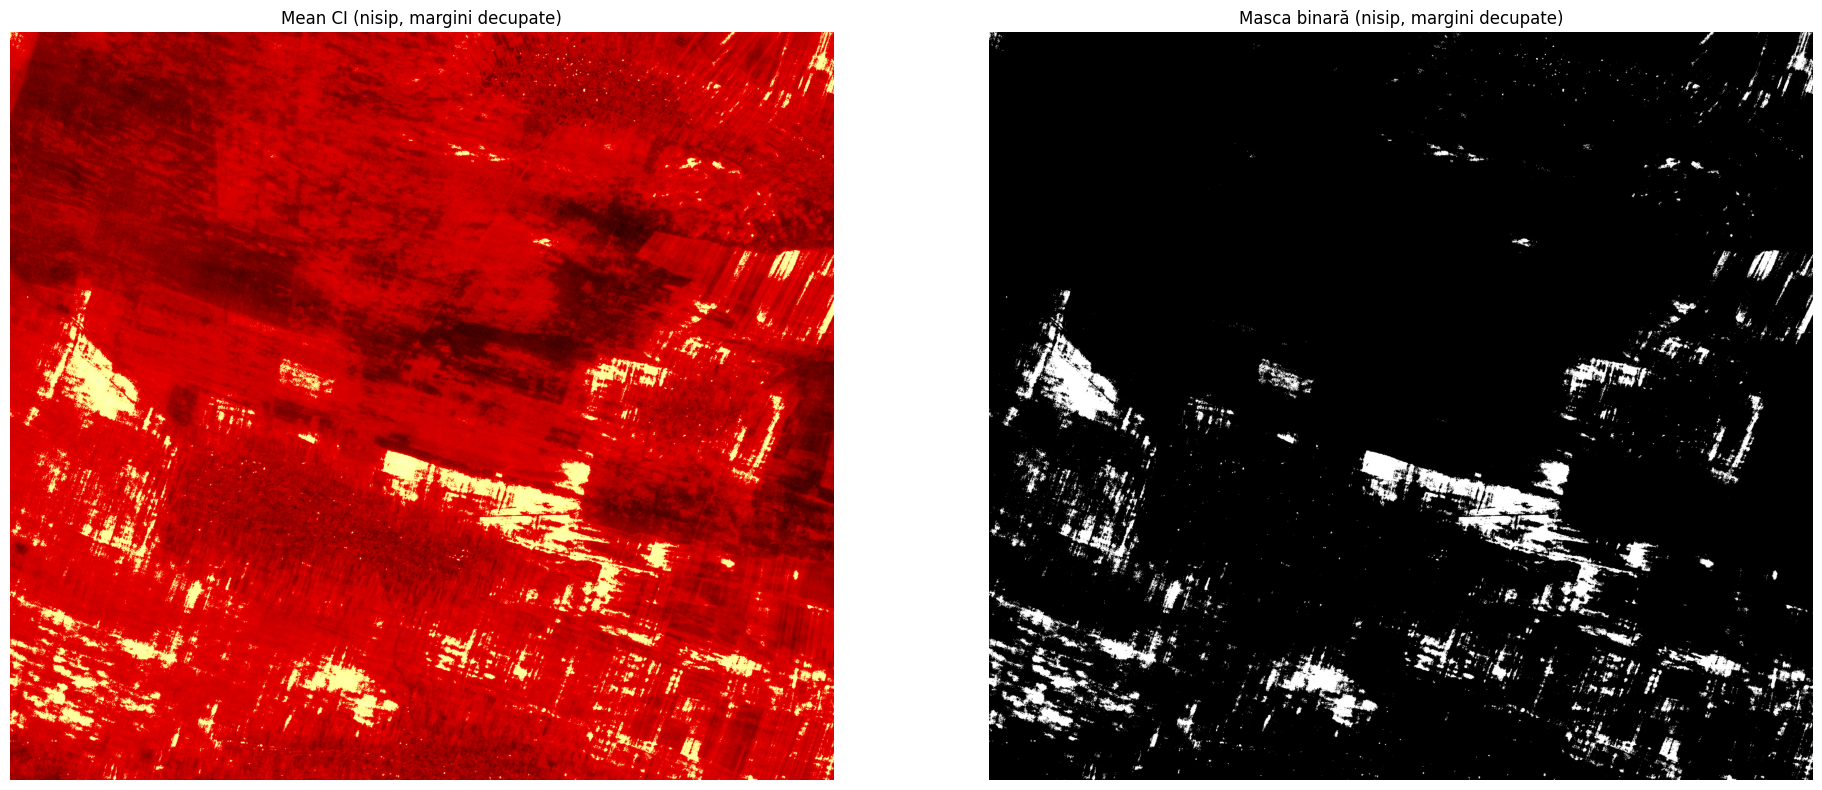

In [ ]:
# Crust Index 2022

import rasterio
from matplotlib import pyplot as plt
import numpy as np
import cv2

base_path = '/content/drive/MyDrive/img/'
months_2021 = ['mar2022', 'apr2022', 'may2022', 'jun2022', 'jul2022',
               'aug2022', 'sep2022', 'oct2022', 'nov2022']

file_paths = [base_path + month + '.tif' for month in months_2021]

# Funcția pentru a calcula CI
def compute_ci_from_file(file_path):
    with rasterio.open(file_path) as src:
        red = src.read(3).astype(float)  # Banda 3: Roșu
        blue = src.read(1).astype(float) # Banda 1: Albastru
        numerator = red - blue
        denominator = red + blue
        ci = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator!=0)
        return ci

# Calcul CI și determinare dimensiune minimă
index_values = []
min_height = float('inf')
min_width = float('inf')

for fp in file_paths:
    ci = compute_ci_from_file(fp)
    index_values.append(ci)
    height, width = ci.shape
    min_height = min(min_height, height)
    min_width = min(min_width, width)

# Redimensionare
dimensions = (min_width, min_height)
index_resized = [cv2.resize(index, dimensions) for index in index_values]

# Normalizare
def normalize_image(image):
    return cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

index_normalized = [normalize_image(index) for index in index_resized]

# Calcul medie
index_mean = np.mean(index_normalized, axis=0).astype(np.uint8)
index_mean_normalized = normalize_image(index_mean)

# Măști binare adaptive
binary_masks = [cv2.adaptiveThreshold(index_n, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                      cv2.THRESH_BINARY, 11, 2) for index_n in index_normalized]
binary_mask_mean = cv2.adaptiveThreshold(index_mean_normalized, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                         cv2.THRESH_BINARY, 11, 2)

# Prag ajustat
m_values = [np.mean(mask) for mask in binary_masks]
m_mean = np.mean(binary_mask_mean)
print(f"Media măști binare (mean): {m_mean}")

avg = 18
print(f"AVG: {avg}")
threshold = m_mean + avg
print(f"Prag final: {threshold}")

# Aplică pragurile
binary_masks = [cv2.threshold(index_n, m, 255, cv2.THRESH_BINARY)[1]
                for index_n, m in zip(index_normalized, m_values)]
_, binary_mask_mean = cv2.threshold(index_mean_normalized, threshold, 255, cv2.THRESH_BINARY)

# Overlay
def create_overlay(base_image, binary_mask):
    return cv2.addWeighted(base_image, 0.5, binary_mask, 0.5, 0)

overlays = [create_overlay(index_n, mask) for index_n, mask in zip(index_normalized, binary_masks)]
overlay_mean = create_overlay(index_mean_normalized, binary_mask_mean)

crop_percent_sides = 0.13  # pentru stânga/dreapta
crop_percent_top = 0.20    # pentru sus
crop_percent_bottom = 0.13 # pentru jos

height, width = overlay_mean.shape[:2]
crop_height_top = int(height * crop_percent_top)      # Pixeli decupați sus
crop_height_bottom = int(height * crop_percent_bottom) # Pixeli decupați jos
crop_width = int(width * crop_percent_sides)          # Pixeli decupați stânga/dreapta

# Calculează noile coordonate
y_start = crop_height_top
y_end = height - crop_height_bottom
x_start = crop_width
x_end = width - crop_width

# Aplică decuparea
cropped_overlay_mean = overlay_mean[y_start:y_end, x_start:x_end]
cropped_binary_mask_mean = binary_mask_mean[y_start:y_end, x_start:x_end]

# Procent pixeli de nisip
sand_pixels = np.sum(cropped_binary_mask_mean == 255)
total_pixels = cropped_binary_mask_mean.shape[0] * cropped_binary_mask_mean.shape[1]
sand_percentage = (sand_pixels / total_pixels) * 100
print(f"Pixeli nisip (mean): {sand_pixels}")
print(f"Pixeli total (mean): {total_pixels}")
print(f"Procentaj pixeli cu nisip (CI mean): {sand_percentage:.2f}%")

# Vizualizare rezultate
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.imshow(cropped_overlay_mean, cmap='hot')
plt.title('Mean CI (nisip, margini decupate)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cropped_binary_mask_mean, cmap='gray')
plt.title('Masca binară (nisip, margini decupate)')
plt.axis('off')

plt.tight_layout()
plt.show()